In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [73]:
config = {
    'csv_path':       'used_cars.csv',
    'drop_cols':      ['ext_col', 'int_col', 'clean_title'],
    'categorical_cols':['brand', 'model', 'fuel_type', 'engine', 'transmission', 'accident'],
    'numeric_cols':   ['model_year', 'milage'],
    'target_col':     'price',
    'train_size':     0.7,       
    'val_size':       0.15,       
    'test_size':      0.15,       
    'random_state':   123,

    # model architecture
    'embed_dim':      16,         
    'mlp_dims':       [256, 128, 64],
    'dropout':        0.2,      

    # training loop
    'batch_size':     128,       
    'num_epochs':     2000,        
    'lr':             0.001,       
    'weight_decay':   0.001,      
}


In [30]:
df = pd.read_csv(config['csv_path'])

# strip symbols & cast
df[config['target_col']] = (
    df[config['target_col']]
      .replace(r'[\$,]', '', regex=True)
      .astype(float)
)
df['milage'] = (
    df['milage']
      .replace(r'\s?mi\.?', '', regex=True)
      .replace(',', '', regex=True)
      .astype(float)
)

df.drop(columns=config['drop_cols'], inplace=True)

X = df.drop(columns=[config['target_col']])
y = np.log1p(df[config['target_col']].to_numpy(dtype=np.float32))

train_frac = config['train_size']
temp_frac  = config['val_size'] + config['test_size']
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    train_size = train_frac,
    random_state= config['random_state']
)
val_frac = config['val_size'] / temp_frac
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    train_size  = val_frac,
    random_state= config['random_state']
)

num_cols   = config['numeric_cols']
num_pipe   = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),
])
Xn_train = num_pipe.fit_transform( X_train[num_cols] )
Xn_val   = num_pipe.transform(    X_val[  num_cols] )
Xn_test  = num_pipe.transform(    X_test[ num_cols] )

cat_cols        = config['categorical_cols']
encoders        = {}
field_dims      = []
Xc_train_cols   = []
Xc_val_cols     = []
Xc_test_cols    = []

for col in cat_cols:
    cats = sorted(X_train[col].dropna().unique().tolist())
    mapping = {v:i for i,v in enumerate(cats)}
    unk_idx = len(cats)           
    encoders[col] = mapping
    field_dims.append(unk_idx+1)  

    def encode_series(s):
        return s.map(lambda v: mapping.get(v, unk_idx)).to_numpy()

    Xc_train_cols.append( encode_series(X_train[col].fillna('')) )
    Xc_val_cols.append(   encode_series(X_val[  col].fillna('')) )
    Xc_test_cols.append(  encode_series(X_test[ col].fillna('')) )

# stack into (n_samples, n_fields)
Xc_train = np.stack(Xc_train_cols, axis=1)
Xc_val   = np.stack(Xc_val_cols,   axis=1)
Xc_test  = np.stack(Xc_test_cols,  axis=1)

# 6) Final check
print("Shapes:")
print("  Xn_train", Xn_train.shape, " Xc_train", Xc_train.shape)
print("  Xn_val  ",   Xn_val.shape,   " Xc_val  ",   Xc_val.shape)
print("  Xn_test ",  Xn_test.shape,  " Xc_test ",  Xc_test.shape)
print("  field_dims", field_dims)


Shapes:
  Xn_train (3207, 2)  Xc_train (3207, 6)
  Xn_val   (401, 2)  Xc_val   (401, 6)
  Xn_test  (401, 2)  Xc_test  (401, 6)
  field_dims [57, 1676, 8, 1051, 58, 3]


In [ ]:
class NFM(nn.Module):
    def __init__(self, field_dims, embed_dim, mlp_dims, dropout, num_numeric):
        super().__init__()
        self.embedding = nn.ModuleList([
            nn.Embedding(card, embed_dim) for card in field_dims
        ])
        self.bn = nn.BatchNorm1d(embed_dim)
        
        input_dim = embed_dim + num_numeric
        layers = []
        for h in mlp_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

            input_dim = h
        layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_cat, x_num):
        embs = torch.stack(
            [emb(x_cat[:, i]) for i, emb in enumerate(self.embedding)],
            dim=1
        )
        sum_emb = embs.sum(1)
        bi_pool = 0.5 * (sum_emb.pow(2) - embs.pow(2).sum(1))
        bi_pool = self.bn(bi_pool)
        
        x = torch.cat([bi_pool, x_num], dim=1)
        return self.mlp(x).squeeze(1)

In [64]:
class UsedCarDataset(Dataset):
    def __init__(self, x_cat, x_num, y):
        self.x_cat = torch.tensor(x_cat, dtype=torch.long)
        self.x_num = torch.tensor(x_num, dtype=torch.float32)
        self.y     = torch.tensor(y,     dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_cat[idx], self.x_num[idx], self.y[idx]
    
train_ds = UsedCarDataset(Xc_train, Xn_train, y_train)
val_ds   = UsedCarDataset(Xc_val,   Xn_val,   y_val)

train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=config['batch_size'], shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NFM(
    field_dims,
    config['embed_dim'],
    config['mlp_dims'],
    config['dropout'],
    len(config['numeric_cols'])
).to(device)

# --- optimizer & scheduler ---
optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=200
)

best_val_loss = float('inf')

criterion    = F.mse_loss
num_epochs   = config['num_epochs']
patience     = 150
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses, val_losses = [], []
train_mae_list, val_mae_list = [], []

for epoch in range(1, num_epochs+1):
    model.train()
    running_train_loss = 0.0
    for xc, xn, y in train_loader:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(xc, xn)
        loss   = criterion(y_pred, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_train_loss += loss.item() * y.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xc, xn, y in val_loader:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            y_pred = model(xc, xn)
            running_val_loss += criterion(y_pred, y).item() * y.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    scheduler.step(epoch_val_loss)

    sum_abs_train, cnt_train = 0.0, 0
    with torch.no_grad():
        for xc, xn, y in train_loader:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            pr = model(xc, xn)
            pred   = torch.expm1(pr)
            actual = torch.expm1(y)
            sum_abs_train += (pred - actual).abs().sum().item()
            cnt_train     += y.size(0)
    train_mae = sum_abs_train / cnt_train
    train_mae_list.append(train_mae)

    sum_abs_val, cnt_val = 0.0, 0
    with torch.no_grad():
        for xc, xn, y in val_loader:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            pr = model(xc, xn)
            pred   = torch.expm1(pr)
            actual = torch.expm1(y)
            sum_abs_val += (pred - actual).abs().sum().item()
            cnt_val     += y.size(0)
    val_mae = sum_abs_val / cnt_val
    val_mae_list.append(val_mae)


    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in {patience} epochs — stopping at epoch {epoch}")
            break

    if epoch == 1 or epoch % 50 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch}/{num_epochs}  "
              f"Train MSE: {epoch_train_loss:.4f}  Val MSE: {epoch_val_loss:.4f}  "
              f"Train MAE: ${train_mae:,.2f}  Val MAE: ${val_mae:,.2f}")

print("\n=== Final Results ===")
print(f"Train  MSE: {train_losses[-1]:.4f},  MAE: ${train_mae_list[-1]:,.2f}")
print(f"Val    MSE: {val_losses[-1]:.4f},  MAE: ${val_mae_list[-1]:,.2f}")


Epoch 1/2000  Train MSE: 100.1569  Val MSE: 96.7904  Train MAE: $45,003.05  Val MAE: $41,250.40
Epoch 50/2000  Train MSE: 0.9612  Val MSE: 0.3845  Train MAE: $18,928.74  Val MAE: $18,440.01
Epoch 100/2000  Train MSE: 0.7218  Val MSE: 0.3019  Train MAE: $14,764.52  Val MAE: $17,383.43
Epoch 150/2000  Train MSE: 0.5773  Val MSE: 0.2585  Train MAE: $11,631.31  Val MAE: $16,239.56
Epoch 200/2000  Train MSE: 0.4509  Val MSE: 0.2534  Train MAE: $9,673.17  Val MAE: $16,230.27
Epoch 250/2000  Train MSE: 0.3563  Val MSE: 0.2395  Train MAE: $8,313.43  Val MAE: $15,479.23
Epoch 300/2000  Train MSE: 0.3024  Val MSE: 0.2340  Train MAE: $7,013.76  Val MAE: $15,250.73
Epoch 350/2000  Train MSE: 0.2520  Val MSE: 0.2120  Train MAE: $6,428.63  Val MAE: $14,546.86
Epoch 400/2000  Train MSE: 0.2101  Val MSE: 0.1990  Train MAE: $5,813.56  Val MAE: $13,859.13
Epoch 450/2000  Train MSE: 0.1794  Val MSE: 0.2023  Train MAE: $4,942.77  Val MAE: $14,044.02
Epoch 500/2000  Train MSE: 0.1653  Val MSE: 0.1839  Trai

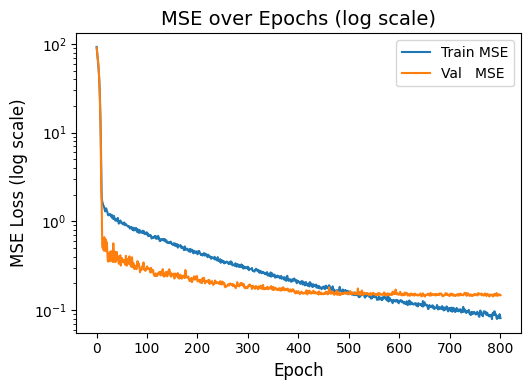

In [75]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses,   label='Val   MSE')
plt.yscale('log')
plt.title("MSE over Epochs (log scale)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss (log scale)", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


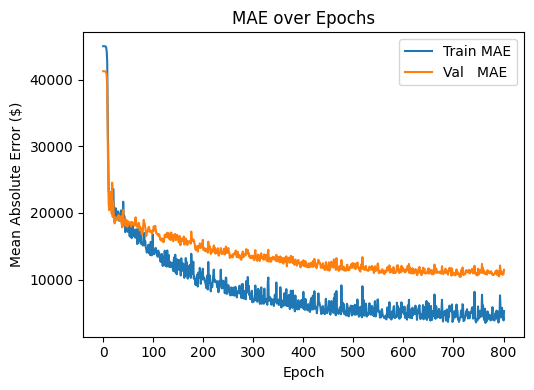

In [76]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(train_mae_list, label='Train MAE')
plt.plot(val_mae_list,   label='Val   MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error ($)")
plt.legend()
plt.tight_layout()
plt.show()

Validation MAE: $11,491.92


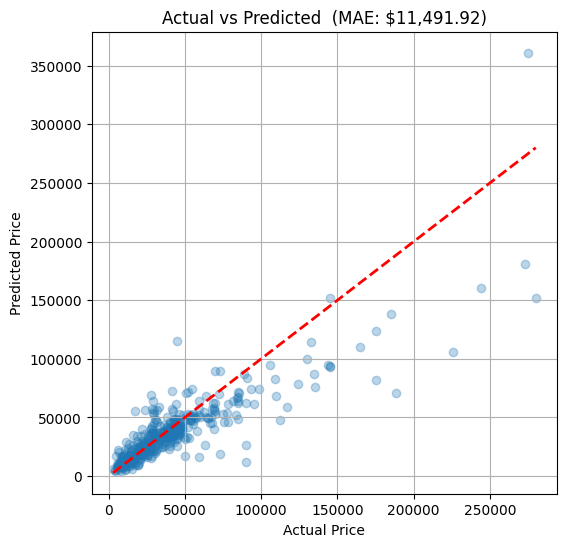

In [77]:
model.eval()
all_pred, all_true = [], []
with torch.no_grad():
    for xc, xn, y in val_loader:
        xc, xn = xc.to(device), xn.to(device)
        pr = model(xc, xn)
        all_pred.append(torch.expm1(pr).cpu().numpy())
        all_true.append(torch.expm1(y).cpu().numpy())

all_pred = np.concatenate(all_pred)
all_true = np.concatenate(all_true)

# 1) Compute MAE
mae = mean_absolute_error(all_true, all_pred)

print(f"Validation MAE: ${mae:,.2f}")

# 2) Plot Actual vs Predicted and annotate MAE
plt.figure(figsize=(6,6))
plt.scatter(all_true, all_pred, alpha=0.3)
plt.plot([all_true.min(), all_true.max()],
         [all_true.min(), all_true.max()],
         'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted  (MAE: ${mae:,.2f})")
plt.grid(True)
plt.show()


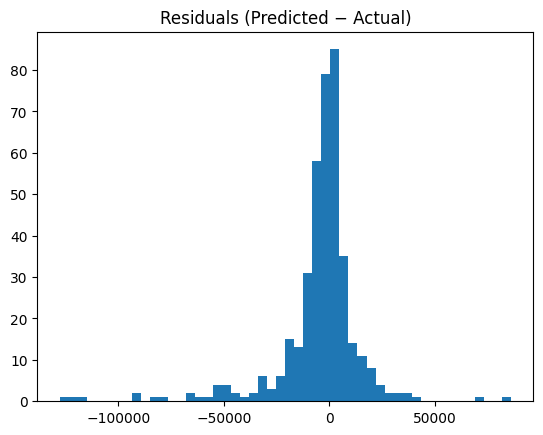

In [78]:
residuals = all_pred - all_true
plt.hist(residuals, bins=50)
plt.title("Residuals (Predicted − Actual)")
plt.show()